In [3]:
import re
import nltk
from hdfs import InsecureClient
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from spellchecker import SpellChecker

In [39]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91996\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [2]:
hdfs_url = "http://localhost:9870"
client = InsecureClient(hdfs_url, user="cran")

In [3]:
output_path = "/user/cran/output/0-r-00000"

In [4]:
inverted_index = {}
with client.read(output_path, encoding='utf-8') as reader:
    for line in reader:
        line = line.split()
        inverted_index[line[0]] = line[1:]
        # inverted_index[line[0]] = [int(doc) for doc in line[1:]]

In [6]:
for word in inverted_index:
    inverted_index[word] = [int(doc) for doc in sorted(list(inverted_index[word]), key=lambda doc: int(doc))]

In [55]:
# sorted_inverted_index = {}
# for word in inverted_index:
#     sorted_inverted_index[word] = [int(doc) for doc in sorted(list(inverted_index[word]), key=lambda doc: int(doc))]

In [8]:
def boolean_and(list1, list2):
    result = []
    i, j = 0, 0
    while i < len(list1) and j < len(list2):
        if list1[i] == list2[j]:
            result.append(list1[i])
            i += 1
            j += 1
        elif list1[i] < list2[j]: i += 1
        else: j += 1
    return result

In [9]:
def boolean_or(list1, list2):
    result = []
    i, j = 0, 0
    while i < len(list1) and j < len(list2):
        if list1[i] == list2[j]:
            result.append(list1[i])
            i += 1
            j += 1
        elif list1[i] < list2[j]:
            result.append(list1[i])
            i += 1
        else:
            result.append(list2[j])
            j += 1
    result.extend(list1[i:])
    result.extend(list2[j:])
    return result

In [10]:
def boolean_not(list1, total_documents):
    all_documents = list(range(total_documents))
    result = []
    i, j = 0, 0
    while i < len(all_documents) and j < len(list1):
        if all_documents[i] == list1[j]:
            i += 1
            j += 1
        elif all_documents[i] < list1[j]:
            result.append(all_documents[i])
            i += 1
        else: j += 1
    result.extend(all_documents[i:])
    return result

In [11]:
def evaluate_boolean_query(query, inverted_index, total_documents):
    def precedence(op):
        if op == 'NOT':
            return 2
        elif op == 'AND':
            return 1
        elif op == 'OR':
            return 0
        else:
            return -1

    def apply_operator(operands, operator):
        if operator == 'AND':
            operand2 = operands.pop()
            operand1 = operands.pop()
            return boolean_and(operand1, operand2)
        elif operator == 'OR':
            operand2 = operands.pop()
            operand1 = operands.pop()
            return boolean_or(operand1, operand2)
        elif operator == 'NOT':
            operand = operands.pop()
            return boolean_not(operand, total_documents)
        else:
            raise ValueError("Invalid operator: " + operator)

    query_tokens = query.split()
    stack = []
    operators = []

    for token in query_tokens:
        if token.upper() in ('AND', 'OR', 'NOT'):
            while (
                operators
                and precedence(operators[-1]) >= precedence(token.upper())
            ):
                operator = operators.pop()
                stack.append(apply_operator(stack, operator))
            operators.append(token.upper())
        else:
            stack.append(inverted_index.get(token, []))

    while operators:
        operator = operators.pop()
        stack.append(apply_operator(stack, operator))

    if stack:
        return stack[0]
    else:
        return []

In [ ]:
evaluate_boolean_query()

In [12]:
total_documents = 1400

In [53]:
str(evaluate_boolean_query("computer AND machine NOT science", inverted_index, 1400))

'[30, 55, 110, 126, 139, 140, 218, 321, 322, 472, 545, 605, 813, 895, 907, 914, 932, 1000, 1062, 1087, 1117, 1162, 1185, 1299]'

Question 2:

In [18]:
queries = []
current_query = None

with open("cran/cran.qry", "r") as file:
    lines = file.readlines()

for line in lines:
    line = line.strip()
    if line.startswith(".I"):
        if current_query is not None:
            queries.append(current_query)
        current_query = ""
    elif current_query is not None:
        if line.startswith('.W'):
            line = line.removeprefix(".W")
        current_query += line + " "

if current_query is not None:
    queries.append(current_query)

In [19]:
number_queries = len(queries)
query_relevant_docs = [[] for i in range(number_queries)]

with open("cran/cranqrel", "r") as file:
    lines = file.readlines()

query_no = 0
last_qid = None
for line in lines:
    parts = line.split()
    if len(parts) == 3:
        query_id = int(parts[0])
        document_number = int(parts[1]) - 1
        relevance = int(parts[2])
        
        if last_qid is None: last_qid = query_id
        elif last_qid != query_id: 
            last_qid = query_id
            query_no += 1
        
        if relevance != -1:
            query_relevant_docs[query_no].append(
                {"docno": document_number, "rel": relevance})

query_relevant_docs = [
    [
        doc['docno'] 
        for doc in sorted(docs, 
                          key=lambda doc: doc['rel'], 
                          reverse=True)
    ] 
    for docs in query_relevant_docs
]

Without stemming

In [4]:
stop_words = set(stopwords.words('english'))

In [19]:
spell = SpellChecker()

In [20]:
def evaluate_query(query: str):
    tokenized_query = word_tokenize(query)
    filtered_query = [word for word in tokenized_query 
                      if word.lower() not in stop_words 
                      and word != '.']
    j = 0
    cnt = 0
    pos1 = []
    pos2 = []
    for word in filtered_query:
        if word in inverted_index:
            if j == 0: pos1 = inverted_index[word]
            if j == 1: pos2 = inverted_index[word]
            j += 1
        cnt += 1
        if j == 2:
            break
    ans = boolean_and(pos1, pos2)
    for i, word in enumerate(filtered_query):
        if i < cnt: continue
        if word in inverted_index:
            pos = inverted_index[word]
            if i % 3:
                ans = boolean_or(ans, pos)
            else:
                ans = boolean_and(ans, pos)
    return ans

In [54]:
def evaluate_system_without_stemming():
    precision_values = [[] for i in range(len(queries))]
    recall_values = [[] for i in range(len(queries))]
    for i, query in enumerate(queries[:]):
        retrieved_docs = evaluate_query(query)        
        if len(retrieved_docs) == 0:
            precision_values[i].append(0)
            recall_values[i].append(0)
        
        for k in range(1, len(retrieved_docs) + 1):
            relevant_docs_retrieved = list(set(retrieved_docs[:k]) 
                                           & set(query_relevant_docs[i]))
            precision = len(relevant_docs_retrieved) / len(retrieved_docs[:k])
            recall = len(relevant_docs_retrieved) / len(query_relevant_docs[i])
            precision_values[i].append(precision)
            recall_values[i].append(recall)
        
        if i == 0:
            interpolated_precision_values = [
                max(precision_values[i][k:]) 
                for k in range(len(recall_values[i]))
            ]
            plt.Figure()
            plt.plot(recall_values[i], precision_values[i], 
                     label='Precision')
            plt.plot(recall_values[i], interpolated_precision_values, 
                     label='Interpolated precision', color='red', linewidth=1)
            plt.title(f'PR curve for \'{query}\'')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend()
            plt.show()  
    MAP = 0
    for j in range(len(queries[:])):
        MAP += sum(precision_values[j]) / len(precision_values[j])
    MAP /= len(queries[:])
    print(f'MAP of the system : {MAP}')

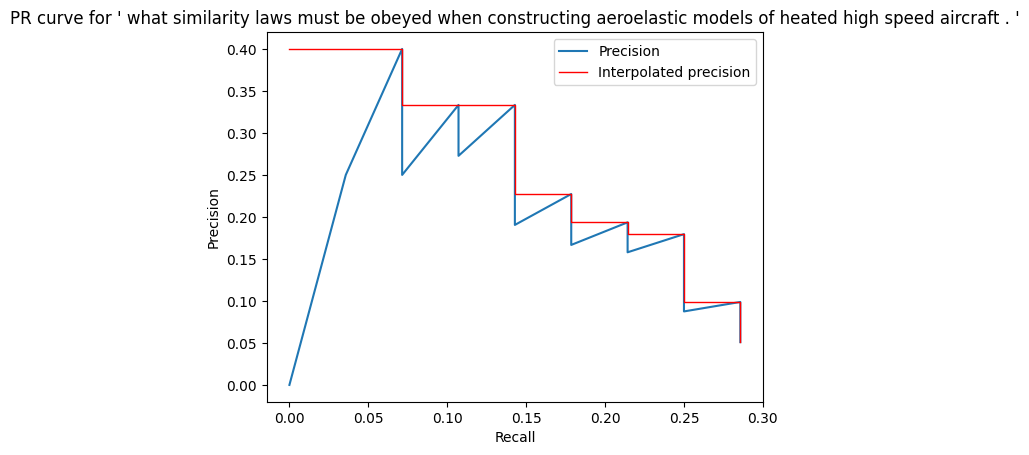

MAP of the system : 0.005328429745698827


In [55]:
evaluate_system_without_stemming()

With Stemming

In [ ]:
stemmed_inverted_index = {}
output_path_stemmed = "/user/cran/stemmed/output/0-r-00000"
with client.read(output_path_stemmed, encoding='utf-8') as reader:
    for line in reader:
        line = line.split()
        stemmed_inverted_index[line[0]] = [int(doc) for doc in line[1:]]

In [5]:
stemmer = PorterStemmer()

In [24]:
stemmed_inverted_index = {}
for word in inverted_index:
    if word in stop_words: continue
    stemmed_word = stemmer.stem(word)
    if stemmed_word not in stemmed_inverted_index:
        stemmed_inverted_index[stemmed_word] = inverted_index[word]
    else:
        stemmed_inverted_index[stemmed_word].extend(inverted_index[word])

stemmed_inverted_index = { word: sorted(docs) for word, docs in stemmed_inverted_index.items()}

In [25]:
def evaluate_query_2(query: str):
    query = re.sub('-,\'', ' ', query)
    tokenized_query = word_tokenize(query)
    filtered_query = [stemmer.stem(word) 
                      for word in tokenized_query 
                      if word.lower() not in stop_words and word != '.']
    j = 0
    cnt = 0
    pos1 = []
    pos2 = []
    for word in filtered_query:
        if word in stemmed_inverted_index:
            if j == 0: pos1 = stemmed_inverted_index[word]
            if j == 1: pos2 = stemmed_inverted_index[word]
            j += 1
        cnt += 1
        if j == 2:
            break
    ans = boolean_or(pos1, pos2)
    for i, word in enumerate(filtered_query):
        if i < cnt: continue
        if word in stemmed_inverted_index:
            pos = stemmed_inverted_index[word]
            if i % 3:
                ans = boolean_or(ans, pos)
            else: 
                ans = boolean_and(ans, pos)
    return ans

In [58]:
def evaluate_system_with_stemming():  
    precision_values = [[] for i in range(len(queries))]
    recall_values = [[] for i in range(len(queries))]
    
    for i, query in enumerate(queries[:]):
        retrieved_docs = evaluate_query_2(query)        
        if len(retrieved_docs) == 0:
            precision_values[i].append(0)
            recall_values[i].append(0)
        
        for k in range(1, len(retrieved_docs) + 1):
            relevant_docs_retrieved = list(set(retrieved_docs[:k]) & 
                                           set(query_relevant_docs[i]))
            precision = len(relevant_docs_retrieved) / len(retrieved_docs[:k])
            recall = len(relevant_docs_retrieved) / len(query_relevant_docs[i])
            precision_values[i].append(precision)
            recall_values[i].append(recall)
        
        if i == 0:
            interpolated_precision_values = [max(precision_values[i][k:]) 
                                             for k in range(len(recall_values[i]))]
            plt.Figure()
            plt.plot(recall_values[i], precision_values[i], label='Precision')
            plt.plot(recall_values[i], interpolated_precision_values, 
                     label='Interpolated precision', color='red', linewidth=1)
            plt.title(f'PR curve for \'{query}\'')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend()
            plt.show()  
    MAP = 0
    for j in range(len(queries[:])):
        MAP += sum(precision_values[j]) / len(precision_values[j])
    MAP /= len(queries[:])
    print(f'MAP of the system : {MAP}')
            

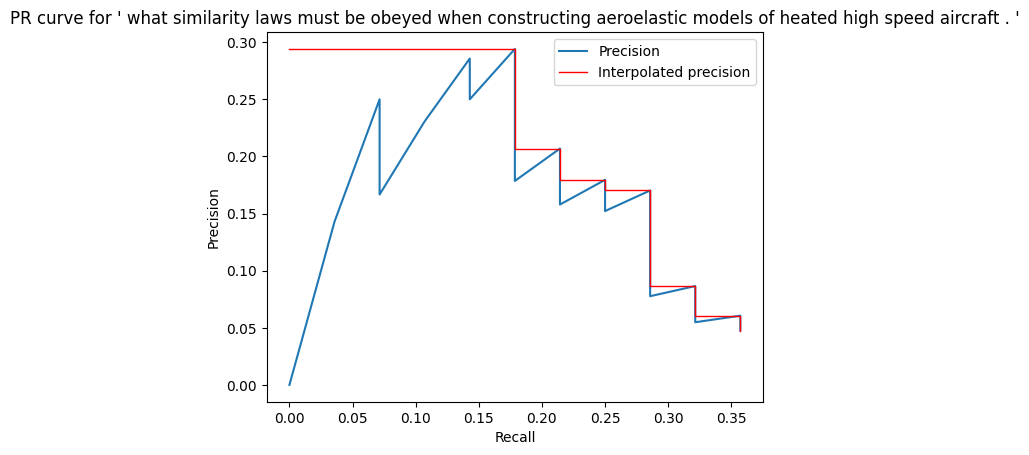

MAP of the system : 0.004860685024724134


In [59]:
evaluate_system_with_stemming()

Zone indexing

In [6]:
cran_zones = {}

def index_document(doc_id, title, body):
    document = {
        "title": title.strip(),
        "body": body.strip()
    }
    
    cran_zones[doc_id] = document

def process_document(file):
    doc_id = None
    current_field = None
    title = ""
    body = ""

    for line in file:
        if line.startswith(".I"):
            if doc_id:
                index_document(doc_id, title, body)
            doc_id = int(line.split()[-1])
            title = ""
            body = ""
            current_field = None
        elif line.startswith(".T"):
            current_field = "title"
        elif line.startswith(".W"):
            current_field = "body"
        elif current_field == "title" or current_field == "body":
            if line.startswith(".A") or line.startswith(".B"):
                current_field = None
            else:
                if current_field == "title":
                    title += line
                elif current_field == "body":
                    body += line

    if doc_id:
        index_document(doc_id, title, body)

with open("cran/cran.all", "r") as file:
    process_document(file)

In [10]:
def clean_and_preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
def remove_stopword(tokens):
    return [token for token in tokens 
            if token and token not in stop_words]

In [12]:
zone_index = {}

for docid, document in list(cran_zones.items()):
    title =  word_tokenize(clean_and_preprocess_text(document["title"]))
    body = word_tokenize(clean_and_preprocess_text(document["body"]))
    
    processed_title = remove_stopword(title)
    processed_body = remove_stopword(body)
    
    for word in title:
        if word not in zone_index:
            zone_index[word] = [{
                "docno": docid,
                "zones": ["title"]
            }]
        else:
            doc_existed = False
            for i, zone in enumerate(zone_index[word]):
                if docid == zone["docno"] and "title" not in zone["zones"]:
                    zone_index[word][i]["zones"].append("title")
                    doc_existed = True
                    break
            if not doc_existed:
                zone_index[word].append({
                    "docno": docid,
                    "zones": ["title"]
                })
    for word in body:
        if word not in zone_index:
            zone_index[word] = [{
                "docno": docid,
                "zones": ["body"]
            }]
        else:
            doc_existed = False
            for i, zone in enumerate(zone_index[word]):
                if docid == zone["docno"]:
                    doc_existed = True
                    if "body" not in zone["zones"]:
                        zone_index[word][i]["zones"].append("body")
                        doc_existed = True
                        break
                    
            if not doc_existed:
                zone_index[word].append({
                    "docno": docid,
                    "zones": ["body"]
                })

In [13]:
def boolean_and_zonal(list1, list2):
    result = []
    i, j = 0, 0

    while i < len(list1) and j < len(list2):
        if list1[i]['docno'] == list2[j]['docno']:
            result.append(list1[i])
            i += 1
            j += 1
        elif list1[i]['docno'] < list2[j]['docno']:
            i += 1
        else:
            j += 1

    return result

In [14]:
def boolean_or_zonal(list1, list2):
    result = []
    i, j = 0, 0

    while i < len(list1) and j < len(list2):
        doc1 = list1[i]['docno']
        doc2 = list2[j]['docno']
        if doc1 == doc2:
            result.append(list1[i])
            i += 1
            j += 1
        elif doc1 < doc2:
            result.append(list1[i])
            i += 1
        else:
            result.append(list2[j])
            j += 1

    result.extend(list1[i:])
    result.extend(list2[j:])

    return result

In [15]:
def evaluate_query_3(query: str):
    tokenized_query = word_tokenize(clean_and_preprocess_text(query))
    filtered_query = [word for word in tokenized_query 
                      if word.lower() not in stop_words and word != '.']
    j = 0
    cnt = 0
    pos1 = []
    pos2 = []
    for word in filtered_query:
        if word in zone_index:
            if j == 0: pos1 = zone_index[word]
            if j == 1: pos2 = zone_index[word]
            j += 1
        cnt += 1
        if j == 2:
            break
    ans = boolean_or_zonal(pos1, pos2)
    for i, word in enumerate(filtered_query):
        if i < cnt: continue
        if word in zone_index:
            pos = zone_index[word]
            if i % 3:
                ans = boolean_or_zonal(ans, pos)
            else:
                ans = boolean_and_zonal(ans, pos)
    return ans

In [16]:
def evaluate_system_zonal():
    precision_values = [[] for i in range(len(queries))]
    recall_values = [[] for i in range(len(queries))]

    for i, query in enumerate(queries[:]):
        retrieved_docs = evaluate_query_3(query)
        retrieved_docs = [doc["docno"] for doc in retrieved_docs]
        if len(retrieved_docs) == 0:
            precision_values[i].append(0)
            recall_values[i].append(0)

        for k in range(1, len(retrieved_docs) + 1):
            relevant_docs_retrieved = list(set(retrieved_docs[:k]) 
                                           & set(query_relevant_docs[i]))
            precision = len(relevant_docs_retrieved) / len(retrieved_docs[:k])
            recall = len(relevant_docs_retrieved) / len(query_relevant_docs[i])
            precision_values[i].append(precision)
            recall_values[i].append(recall)
            
        if i == 0:
            interpolated_precision_values = [max(precision_values[i][k:]) 
                                             for k in range(len(recall_values[i]))]
            plt.Figure()
            plt.plot(recall_values[i], precision_values[i], label='Precision')
            plt.plot(recall_values[i], interpolated_precision_values, 
                     label='Interpolated precision', color='red',linewidth=1)
            plt.title(f'PR curve for \'{query}\'')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend()
            plt.show()
    MAP = 0
    for j in range(len(queries[:])):
        MAP += sum(precision_values[j]) / len(precision_values[j])
    MAP /= len(queries[:])
    print(f'MAP of the system : {MAP}')

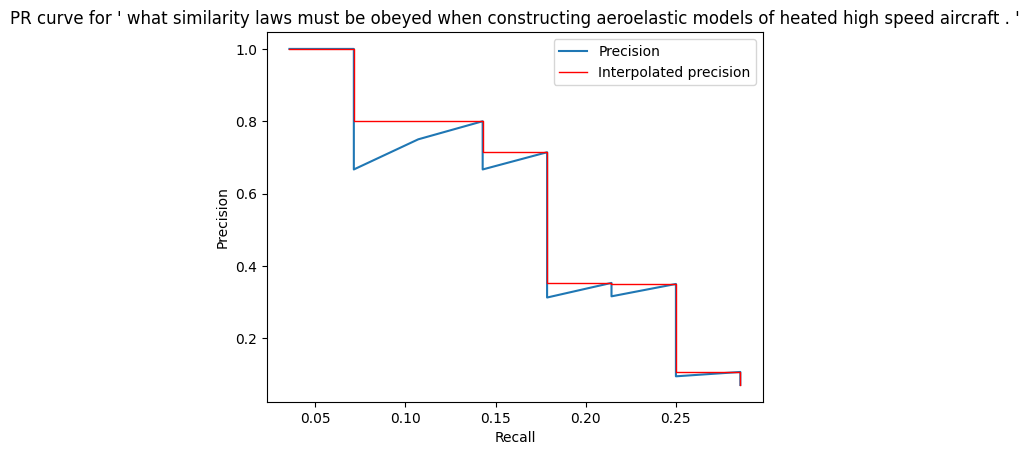

MAP of the system : 0.02936858287424262


In [20]:
evaluate_system_zonal()

Challenge problem

In [21]:
def score_docs(docs, query, titleWeight=0.3, bodyWeight=0.7):
    tokenized_query = word_tokenize(clean_and_preprocess_text(query))
    filtered_query = [word for word in tokenized_query 
                      if word.lower() not in stop_words and word != '.']
    scores = {doc: 0 for doc in docs}
    docScore = 0
    for token in filtered_query:
        if token not in zone_index: continue
        q_docs = [doc for doc in zone_index[token] if doc['docno'] in scores]
        for doc in q_docs:
            if "title" in doc["zones"]:
                scores[doc['docno']] += titleWeight
            if "body" in doc["zones"]:
                scores[doc['docno']] += bodyWeight
    return scores              

In [22]:
def rank_docs():
    for i, query in enumerate(queries[:1]):
        retrieved_docs = evaluate_query_3(query)
        retrieved_docs = [doc["docno"] for doc in retrieved_docs]
        scores = score_docs(retrieved_docs, query)
        ranked_docs = [doc_score 
                       for doc_score 
                       in sorted(list(scores.items()), 
                        reverse=True, key=lambda item: item[1])]
        return ranked_docs

In [23]:
rank_docs()

[(792, 4.0),
 (12, 3.4000000000000004),
 (746, 3.0),
 (172, 2.8),
 (878, 2.8),
 (51, 2.7),
 (141, 2.7),
 (435, 2.7),
 (747, 2.7),
 (1144, 2.7),
 (1147, 2.7),
 (78, 2.4),
 (184, 2.4),
 (209, 2.4),
 (252, 2.4),
 (914, 2.4),
 (14, 2.0999999999999996),
 (329, 2.0999999999999996),
 (374, 2.0999999999999996),
 (52, 2.0),
 (204, 2.0),
 (280, 2.0),
 (309, 2.0),
 (429, 2.0),
 (430, 2.0),
 (606, 2.0),
 (700, 2.0),
 (876, 2.0),
 (945, 2.0),
 (1063, 2.0),
 (1111, 2.0),
 (202, 1.7),
 (211, 1.7),
 (302, 1.7),
 (311, 1.7),
 (378, 1.7),
 (441, 1.7),
 (593, 1.7),
 (1012, 1.7),
 (1089, 1.7),
 (1167, 1.7),
 (1169, 1.7),
 (1303, 1.7),
 (1380, 1.7),
 (24, 1.4),
 (29, 1.4),
 (36, 1.4),
 (58, 1.4),
 (67, 1.4),
 (69, 1.4),
 (82, 1.4),
 (169, 1.4),
 (195, 1.4),
 (214, 1.4),
 (216, 1.4),
 (274, 1.4),
 (292, 1.4),
 (352, 1.4),
 (364, 1.4),
 (476, 1.4),
 (624, 1.4),
 (629, 1.4),
 (658, 1.4),
 (721, 1.4),
 (726, 1.4),
 (908, 1.4),
 (917, 1.4),
 (982, 1.4),
 (986, 1.4),
 (1043, 1.4),
 (1110, 1.4),
 (1300, 1.4),
 (1

In [24]:
list(cran_zones.items())[-1]

(1400,
 {'title': 'the buckling shear stress of simply-supported infinitely\nlong plates with transverse stiffeners .',
  'body': 'the buckling shear stress of simply-supported infinitely\nlong plates with transverse stiffeners .\n  this report is an extension of previous theoretical\ninvestigations of the elastic buckling in shear of flat\nplates reinforced by transverse stiffeners . the plates are treated\nas infinitely long and simply-supported along the long\nsides . stiffeners are spaced at regular intervals, dividing the plate\ninto a number of panels of uniform size . the effect\nob bending and torsional stiffnesses of the stiffener upon the buckling\nshear stress is calculated for the complete range\nof stiffnesses, for panels with ratios of width to stiffener spacing of\ngraphical forms .'})

In [25]:
def score(d, q, titleWeight=0.3, bodyWeight=0.7):
    if q not in zone_index: return 0
    doc = [doc for doc in zone_index[q] if doc['docno'] == d]
    sc = 0
    if "title" in doc[0]["zones"]:
        sc += titleWeight
    if "body" in doc[0]["zones"]:
        sc += bodyWeight
    return sc

In [26]:
def score_title(d, q):
    s = 0
    for token in q:
        if token not in zone_index: continue
        posting_list = zone_index[token]
        if d in [doc['docno'] 
                 for doc in posting_list 
                 if doc['docno'] == d and "title" in doc['zones']]:
            s += 1
    normalized_s = float(s / len(q))
    if normalized_s >= 0.2: return 1
    return 0

In [27]:
def score_body(d, q):
    s = 0
    for token in q:
        if token not in zone_index: continue
        posting_list = zone_index[token]
        if d in [doc['docno'] 
                 for doc in posting_list 
                 if doc['docno'] == d and "body" in doc['zones']]:
            s += 1
    normalized_s = float(s / len(q))
    if normalized_s >= 0.2: return 1
    return 0

In [28]:
def calculate_weight():
    all_docs = [doc for doc, _ in cran_zones.items()]
    trainings = [["doc", "query", "St", "Sb", "Judgment"]]
    for i, query in enumerate(queries[:100]):
        relevant_docs = query_relevant_docs[i]
        non_relevant_docs = list(set(all_docs) - set(query_relevant_docs[i]))
        
        tokenized_query = word_tokenize(clean_and_preprocess_text(query))
        filtered_query = [word for word in tokenized_query 
                          if word.lower() not in stop_words and word != '.']
        
        for rel_doc in relevant_docs:
            St = score_title(rel_doc, filtered_query)
            Sb = score_body(rel_doc, filtered_query)
            trainings.append([rel_doc, i, St, Sb, "Relevant"])    
        for non_rel_doc in non_relevant_docs:
            St = score_title(non_rel_doc, filtered_query)
            Sb = score_body(non_rel_doc, filtered_query)
            trainings.append([non_rel_doc, i, St, Sb, "Non-Relevant"])
        
    n_10_r = 0
    n_10_n = 0
    n_01_r = 0
    n_01_n = 0
    
    for i, training in enumerate(trainings):
        if not i: continue
        if training[2] == 1 and training[3] == 0:
            if training[4] == 'Relevant': n_10_r += 1
            else: n_10_n += 1
        if training[2] == 0 and training[3] == 1:
            if training[4] == 'Relevant': n_01_r += 1
            else: n_01_n += 1
    
    optimal_weight = float((n_10_r + n_01_n) / (n_10_r + n_10_n + n_01_r + n_01_n))
    print(f'{optimal_weight}')

In [29]:
calculate_weight()            

0.9896562371346233
